In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from computer_vision.self_supervised.dino.func import ImageData, CollateFn, CollateSingleImage, ImageOriginalData, Model, clip_loss, LightningModel, Config
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import LearningRateMonitor
import cv2
import albumentations as A

seed_everything(42)

Global seed set to 42


42

Global seed set to 42


42

In [7]:
path = Path.home() / 'OneDrive - Seagroup/ai/computer_vison/coco/coco2017'
train_files = [str(file) for file in (path / 'train2017').glob("*.jpg")]
valid_files = [str(file) for file in (path / 'test2017').glob("*.jpg")]

train_data = ImageData(train_files)
train_dl = DataLoader(
    train_data,
    Config.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=Config.num_workers,
    pin_memory=True,
    collate_fn=CollateFn(),
)

valid_data = ImageOriginalData(valid_files)
valid_dl = DataLoader(
    valid_data,
    Config.batch_size*2,
    shuffle=False,
    drop_last=False,
    num_workers=Config.num_workers,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

In [8]:
lr_monitor = LearningRateMonitor(logging_interval='step')
teacher = Model()
epochs = 2
lightning_model = LightningModel(
    model=teacher,
    learning_rate=1e-3,
    loss_fn=clip_loss,
    valid_files=valid_files,
    max_epochs=epochs,
    weight_decay=0.1,
    batch_size=Config.batch_size,
)

trainer = Trainer(
    accelerator='gpu',
    max_epochs=epochs,
    precision=16,
    deterministic=True,
    callbacks=[lr_monitor],
    num_sanity_val_steps=0,
)
trainer.fit(lightning_model, train_dl, valid_dl)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance.

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 34.5 M
--------------------------------
34.5 M    Trainable params
0         Non-trainable params
34.5 M    Total params
68.926    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\Kevin\miniconda3\envs\hehe\lib\site-packages\lightning\pytorch\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [14]:
image_orig_data = ImageOriginalData(valid_files)
image_orig_dl = DataLoader(
    image_orig_data,
    Config.batch_size*4,
    shuffle=False,
    drop_last=False,
    num_workers=Config.num_workers,
    pin_memory=True,
    collate_fn=CollateSingleImage(),
)

device = 'cuda'
teacher = teacher.eval().to(device)
embedding = []
with torch.no_grad():
    for x in tqdm(image_orig_dl):
        out = teacher(x.to(device))
        embedding.append(out.cpu())
    embedding = torch.cat(embedding, dim=0)


100%|██████████| 318/318 [02:00<00:00,  2.63it/s]


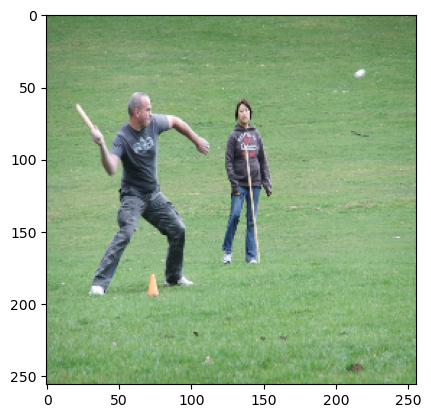

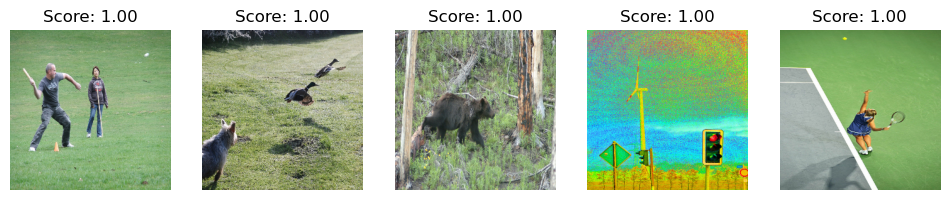

In [20]:
resize = A.Resize(256, 256)


def get_closest(embedding: torch.FloatTensor, i: int):
    similarity = embedding @ embedding[i,:].T
    scores, idx = similarity.topk(5)
    return scores, idx

def read_image(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_closest_pairs(embedding, i, files):
    img = resize(image=read_image(files[i]))
    plt.imshow(img['image'])
    scores, idx = get_closest(embedding, i)

    fig, axes = plt.subplots(1, len(idx), figsize=(12, 5))
    for i, score, ax in zip(idx, scores, axes):
        img = resize(image=read_image(files[i]))
        ax.imshow(img['image'])
        ax.set_title(f"Score: {score:.2f}")
        ax.axis('off')

    plt.show()
    
    
i = 4
plot_closest_pairs(embedding, i, valid_files)

In [16]:
embedding

tensor([[-0.0027, -0.0107,  0.0284,  ...,  0.0145, -0.0311,  0.0090],
        [ 0.0035,  0.0211,  0.0130,  ...,  0.0135, -0.0009, -0.0004],
        [-0.0056, -0.0409,  0.0163,  ..., -0.0021, -0.0377,  0.0072],
        ...,
        [ 0.0074,  0.0359, -0.0269,  ..., -0.0051,  0.0445, -0.0137],
        [-0.0087,  0.0011,  0.0251,  ...,  0.0191, -0.0120,  0.0210],
        [ 0.0016,  0.0121,  0.0194,  ...,  0.0147, -0.0124,  0.0027]])